# Detección de Tumores Malignos

## Librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from pickle import dump

## Funciones

In [2]:
def matrizConfusion(yReal,yPred,Titulo="Matriz de confusión", verClasif=True, verFig=True, verPPM=True):
    LABELS=['Benigno','Maligno']
    conf_matrix = confusion_matrix(y_true = yReal,y_pred= yPred)
    if verFig:
        plt.figure(figsize=(4, 4))
        sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
        if verClasif: repCla=classification_report(yReal, yPred)
        else: repCla = ""
        plt.title(f"{Titulo}\n {repCla}" )
        plt.ylabel('Observación')
        plt.xlabel('Predicción')
        plt.show()
    numDatB = yReal.value_counts()[0]
    numDatM = yReal.value_counts()[1]
    numDat= yReal.count()
    PPM=conf_matrix[1,1]/numDatM
    print (f"Cantidad   (Benigno): {numDatB}")
    print (f"Cantidad   (Maligno): {numDatM}")
    print (f"Cantidad     (Total): {numDat}")
    print(f"Exactitud  de  modelo: {accuracy_score(yReal, yPred)*100:.4f} %")
    if verPPM: 
        print(f"\033[1;32mPrecisión en la Predicción de tumores Malignos: {PPM*100:.4f} % \033[0m\n\n\n")
    else:
        print(f"\n\n\n")
    return PPM


def modeloRegLog(xTrain, yTrain, xTest, yTest,TipoBalanceo=""):
    # La entrada de datos xTrain, yTrain, son según balanceo preparado
    modeloRegLog = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg") # Modelo de regresión logistica
    modeloRegLog.fit(xTrain, yTrain) # Entrenamiento del modelo
    nomModel="RegLog "+ TipoBalanceo +".pkl" # Nombre del modelo según tipo de balanceo enviado
    dump(modeloRegLog,open(nomModel,'wb')) # Guardar el modelo
    # Verificación con los datos de entrenamiento
    yPred = modeloRegLog.predict(xTrain)
    matrizConfusion(yTrain,yPred,Titulo="Regresión Logaritmica\nEntrenamiento\n" + TipoBalanceo, verClasif=False, verPPM=False)
    
    # Verificación con los datos de prueba
    yPred = modeloRegLog.predict(xTest)
    return matrizConfusion(yTest,yPred,Titulo="Regresión Logaritmica\nPrueba \n" + TipoBalanceo, verClasif=False)


def modeloBagg(xTrain, yTrain, xTest, yTest,TipoBalanceo=""):
    # La entrada de datos xTrain, yTrain, son según balanceo preparado
    balancedclasifica = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(), sampling_strategy='auto', replacement=False, random_state=0)
    balancedclasifica.fit(xTrain, yTrain)
    nomModel="Bagging "+ TipoBalanceo +".pkl"
    dump(balancedclasifica,open(nomModel,'wb'))

    # Verificación con los datos de entrenamiento
    yPred = balancedclasifica.predict(xTrain)
    matrizConfusion(yTrain,yPred,Titulo="Clasificación por método Bagging\nEntrenamiento\n" + TipoBalanceo, verClasif=False, verPPM=False)
    
    # Verificación con los datos de prueba
    yPred = balancedclasifica.predict(xTest)
    return matrizConfusion(yTest,yPred,Titulo="Clasificación por método Bagging\nPrueba\n" + TipoBalanceo, verClasif=False)


def modeloArbDes(xTrain, yTrain, xTest, yTest,TipoBalanceo=""):
    # Arbol de decision con profundidad = 4
    arbolDecision = DecisionTreeClassifier(criterion='entropy',
                                                min_samples_split=20,
                                                min_samples_leaf=5,
                                                max_depth = 4,
                                                class_weight={1:3.5})
    arbolDecision.fit(xTrain, yTrain)
    nomModel="ArbDes "+ TipoBalanceo +".pkl"
    dump(arbolDecision,open(nomModel,'wb'))
    # Verificación con los datos de entrenamiento
    yPred = arbolDecision.predict(xTrain)
    matrizConfusion(yTrain,yPred,Titulo="Clasificación por método Arbol de decisión\nEntrenamiento\n" + TipoBalanceo, verClasif=False, verPPM=False)
    
    # Verificación con los datos de prueba
    yPred = arbolDecision.predict(xTest)
    return matrizConfusion(yTest,yPred,Titulo="Clasificación por método Arbol de decisión\nPrueba\n" + TipoBalanceo, verClasif=False)    


## Lectura y tratamiento de datos

In [3]:
"""
id	:	Número único de muestra			
Diagnostico	:	(M: Maligno, B:Benigno)			
radioMD	:	radio del centro a los puntos del perímetro	(	Media	)
texturaMD	:	desviación estándar de los valores de la escala de grises	(	Media	)
perímetroMD	:	perímetro	(	Media	)
áreaMD	:	área	(	Media	)
suavidadMD	:	variación local en longitudes de radio	(	Media	)
compacidadMD	:	compacidad (perímetro ^ 2 / área - 1.0)	(	Media	)
concavidadMD	:	severidad de las porciones cóncavas del contorno	(	Media	)
puntos cóncavosMD	:	número de porciones cóncavas del contorno	(	Media	)
simetríaMD	:	simetría	(	Media	)
dimensión fractal MD	:	"aproximación a la línea de costa" - 1	(	Media	)
radioSE	:	radio del centro a los puntos del perímetro	(	Desv Estándar	)
texturaSE	:	desviación estándar de los valores de la escala de grises	(	Desv Estándar	)
perímetroSE	:	perímetro	(	Desv Estándar	)
áreaSE	:	área	(	Desv Estándar	)
suavidadSE	:	variación local en longitudes de radio	(	Desv Estándar	)
compacidadSE	:	compacidad (perímetro ^ 2 / área - 1.0)	(	Desv Estándar	)
concavidadSE	:	severidad de las porciones cóncavas del contorno	(	Desv Estándar	)
puntos cóncavosSE	:	número de porciones cóncavas del contorno	(	Desv Estándar	)
simetríaSE	:	simetría	(	Desv Estándar	)
dimensión fractal SE	:	"aproximación a la línea de costa" - 1	(	Desv Estándar	)
radioPeor	:	radio del centro a los puntos del perímetro	(	Peor Valor	)
texturaPeor	:	desviación estándar de los valores de la escala de grises	(	Peor Valor	)
perímetroPeor	:	perímetro	(	Peor Valor	)
áreaPeor	:	área	(	Peor Valor	)
suavidadPeor	:	variación local en longitudes de radio	(	Peor Valor	)
compacidadPeor	:	compacidad (perímetro ^ 2 / área - 1.0)	(	Peor Valor	)
concavidadPeor	:	severidad de las porciones cóncavas del contorno	(	Peor Valor	)
puntos cóncavosPeor	:	número de porciones cóncavas del contorno	(	Peor Valor	)
simetríaPeor	:	simetría	(	Peor Valor	)
dimensión fractal Peor	:	"aproximación a la línea de costa" - 1	(	Peor Valor	)

"""

'\nid\t:\tNúmero único de muestra\t\t\t\nDiagnostico\t:\t(M: Maligno, B:Benigno)\t\t\t\nradioMD\t:\tradio del centro a los puntos del perímetro\t(\tMedia\t)\ntexturaMD\t:\tdesviación estándar de los valores de la escala de grises\t(\tMedia\t)\nperímetroMD\t:\tperímetro\t(\tMedia\t)\náreaMD\t:\tárea\t(\tMedia\t)\nsuavidadMD\t:\tvariación local en longitudes de radio\t(\tMedia\t)\ncompacidadMD\t:\tcompacidad (perímetro ^ 2 / área - 1.0)\t(\tMedia\t)\nconcavidadMD\t:\tseveridad de las porciones cóncavas del contorno\t(\tMedia\t)\npuntos cóncavosMD\t:\tnúmero de porciones cóncavas del contorno\t(\tMedia\t)\nsimetríaMD\t:\tsimetría\t(\tMedia\t)\ndimensión fractal MD\t:\t"aproximación a la línea de costa" - 1\t(\tMedia\t)\nradioSE\t:\tradio del centro a los puntos del perímetro\t(\tDesv Estándar\t)\ntexturaSE\t:\tdesviación estándar de los valores de la escala de grises\t(\tDesv Estándar\t)\nperímetroSE\t:\tperímetro\t(\tDesv Estándar\t)\náreaSE\t:\tárea\t(\tDesv Estándar\t)\nsuavidadSE\t:\t

###  Leer datos

In [4]:
df = pd.read_csv("./data/wdbc.data")
print("Número de lineas leidas: ", df.shape[0])
numDat=df.shape[0]
df.info()

Número de lineas leidas:  569
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      569 non-null    int64  
 1   Diagnostico             569 non-null    object 
 2   radioMD                 569 non-null    float64
 3   texturaMD               569 non-null    float64
 4   perímetroMD             569 non-null    float64
 5   áreaMD                  569 non-null    float64
 6   suavidadMD              569 non-null    float64
 7   compacidadMD            569 non-null    float64
 8   concavidadMD            569 non-null    float64
 9   puntos cóncavosMD       569 non-null    float64
 10  simetríaMD              569 non-null    float64
 11  dimensión fractal MD    569 non-null    float64
 12  radioSE                 569 non-null    float64
 13  texturaSE               569 non-null    float64
 14  perímetroSE 

### Verificar balance de casos

Total de pacientes: 569
Pacientes diagnosticados como Benigno: 357
Pacientes diagnosticados como Maligno: 212
Los casos benignos superan en 68.40% a los casos malignos por lo que se recomienda un balanceo de datos, existe clases desequilibradas


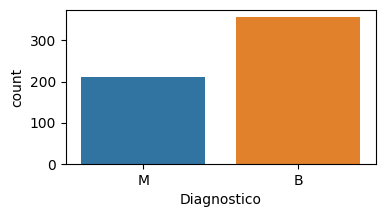

In [5]:
# Se observa que los datos no tienen valores nulos por lo que se continúa con esa información
plt.figure(figsize = (4, 2))
Diagnostico=df['Diagnostico'].value_counts()
numDatB=Diagnostico['B']
numDatM=Diagnostico['M']
tBM=numDatB+numDatM
rBM=numDatB/numDatM
print(f"Total de pacientes: {tBM}\nPacientes diagnosticados como Benigno: {numDatB}\nPacientes diagnosticados como Maligno: {numDatM}")
if rBM>1.2 :
    print(f"Los casos benignos superan en {((rBM-1)*100):.2f}% a los casos malignos por lo que se recomienda un balanceo de datos, existe clases desequilibradas")
elif rBM<0.8:
    print(f"Los casos malignos superan en {((1-rBM)*100):.2f}% a los casos benignos por lo que se recomienda un balanceo de datos, existe clases desequilibradas")
sns.countplot(x='Diagnostico',data=df)
plt.show()

###  Preparación de datos categóricos

In [6]:
dataAnalisis=df[df.columns.drop(["id"])]
# cambia la variable categórica "Diagnostico" a numérica,con dropfirst eliminamos la primera columna
dataAnalisis=pd.get_dummies(dataAnalisis,columns=['Diagnostico'], drop_first=True) 
# Mover la variable "Diagnostico" a la primera posición
col = dataAnalisis.pop('Diagnostico_M')
# Queda la columna Diagnostido representando "0" como caso Benigno y "1" como caso Maligno
dataAnalisis.insert(loc= 0 , column= 'Diagnostico', value= col)
dataAnalisis.head(2)

,Diagnostico,radioMD,texturaMD,perímetroMD,áreaMD,suavidadMD,compacidadMD,concavidadMD,puntos cóncavosMD,simetríaMD,...,radioPeor,texturaPeor,perímetroPeor,áreaPeor,suavidadPeor,compacidadPeor,concavidadPeor,puntos cóncavosPeor,simetríaPeor,dimensión fractal Peor
0,1,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


####    Verificar correlaciones y eliminar las menores correlaciones para hacer más simple el modelado

In [7]:
Variables=list(dataAnalisis.columns.values)
numVariables=len(Variables)
errorCorrMin=0.05 #error minimo permitido en la correlación entre la variable Diagnostico y las demas, se eliminarán las variables con una correlación más baja
VarEliminar=[]
for i in range(1,31):
  corrV0Vi=np.corrcoef(dataAnalisis[Variables[0]], dataAnalisis[Variables[i]])[0,1]
  #print(f"Correlación de '{Variables[0]}' con '{Variables[i]}': {corrV0Vi}")
  if abs(corrV0Vi)<errorCorrMin: VarEliminar.append(Variables[i])
#print(VarEliminar)
dataAnalisis=dataAnalisis[dataAnalisis.columns.drop(VarEliminar)] #se eliminan las variables con ceficiente de correlación menor al error permitido

<AxesSubplot: title={'center': 'Correlacion de variables: metodo Pearson'}>

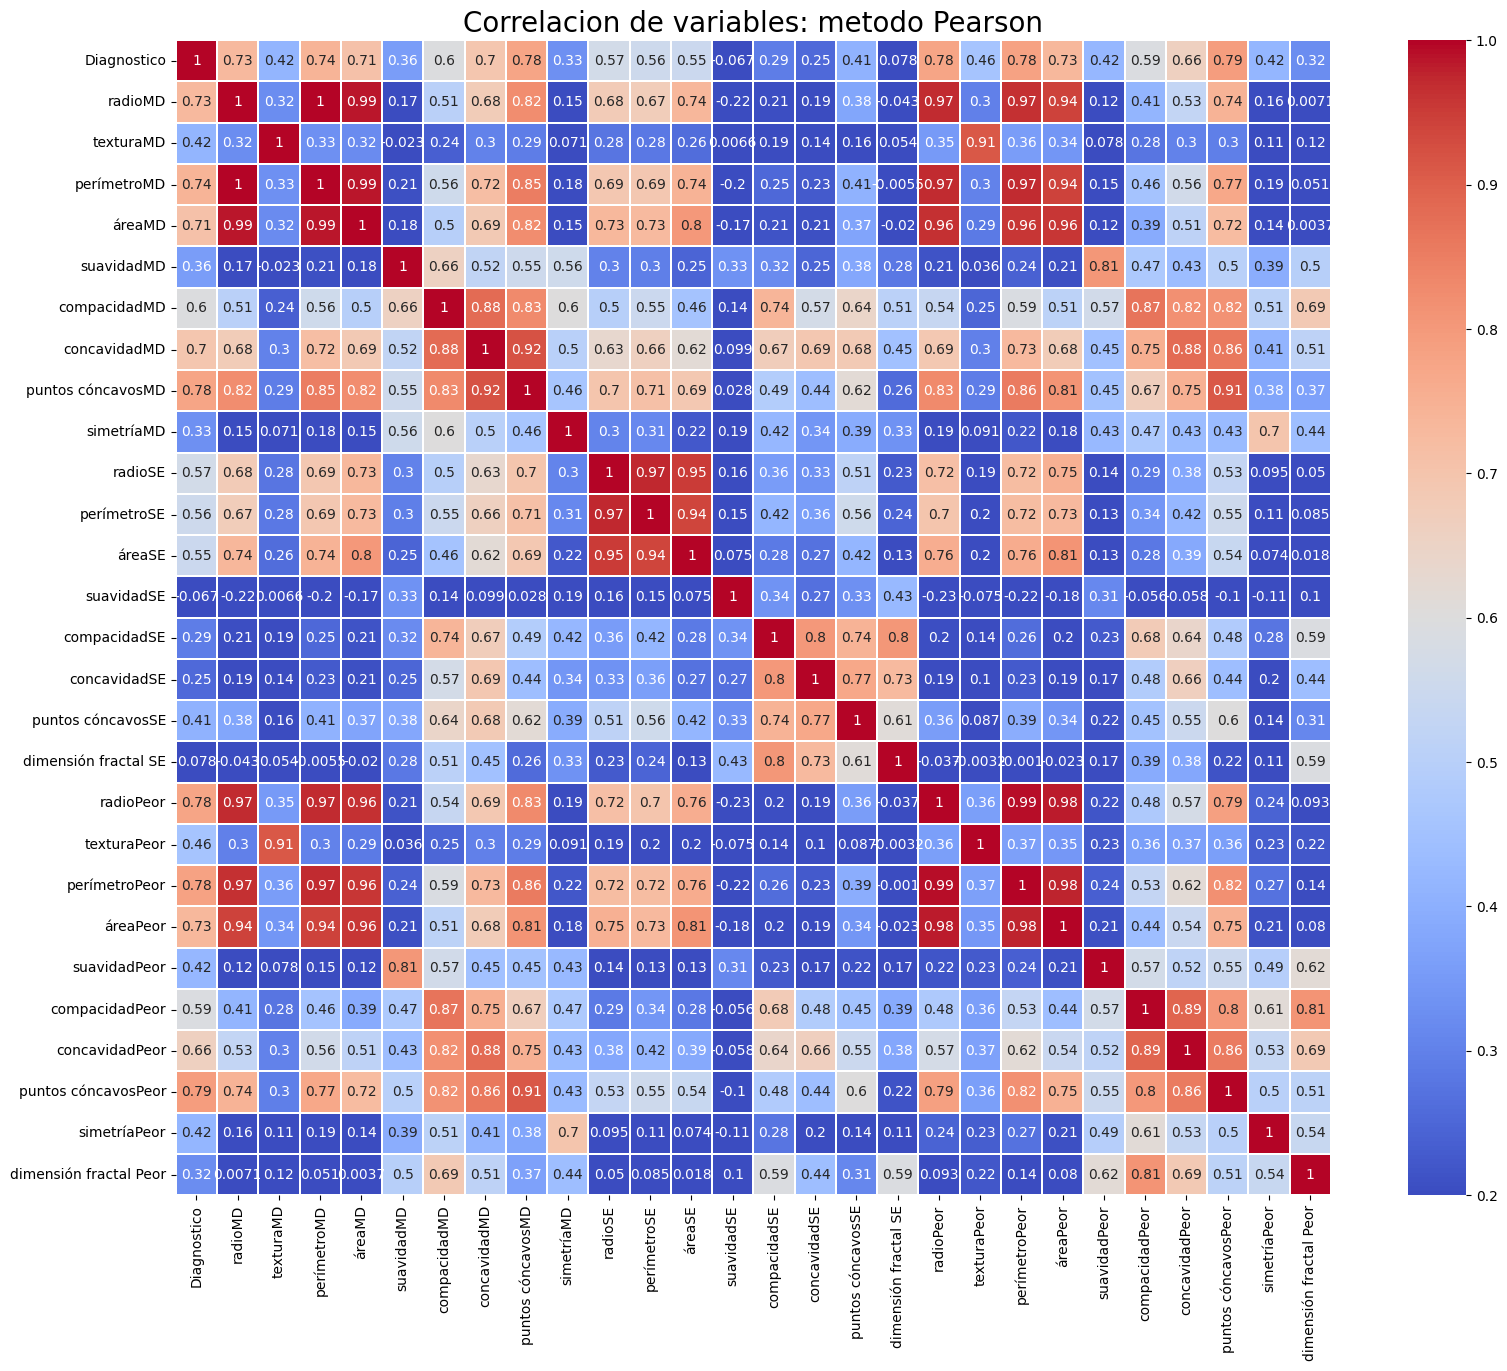

In [8]:
# Diagrama de calor para las correlaciones, esto es solo para visualizarlas ya que en el paso anterior se eliminó las menores al error permitido
colormap = plt.cm.coolwarm #.viridis
corrVar=dataAnalisis.astype(float).corr()
plt.figure(figsize=(20,15))
plt.title('Correlacion de variables: metodo Pearson', y=1, size=20)
sns.heatmap(corrVar,linewidths=0.05,vmax=1.0,vmin=0.2, square=True, cmap=colormap, linecolor='white', annot=True)

## Seleccion datos para entrenamiento y pruebas

In [9]:
dataX = dataAnalisis[dataAnalisis.columns.drop("Diagnostico")]
dataY = dataAnalisis["Diagnostico"]  #queda la columna Diagnostido representando "0" como caso Benigno y "1" como caso Maligno
#separamos los datos en dos grupos "train" con 70% y "test" con el 30%
#dataX.info()
xTrainCopy, xTestCopy, yTrainCopy, yTestCopy = train_test_split(dataX, dataY, test_size=0.3)
numDatTrain = yTrainCopy.count()
numDatTrainB = yTrainCopy.value_counts()[0]
numDatTrainM = yTrainCopy.value_counts()[1]
numDatTest= yTestCopy.count()
numDatTestB = yTestCopy.value_counts()[0]
numDatTestM = yTestCopy.value_counts()[1]
print(f"Existen {numDatTrain} datos en la muestra de entrenamiento(Train), de estos {numDatTrainB} son Benignos y {numDatTrainM} son Malignos")
print(f"Existen {numDatTest} datos en la muestra de prueba(Test), de estos {numDatTestB} son Benignos y {numDatTestM} son Malignos")


Existen 398 datos en la muestra de entrenamiento(Train), de estos 243 son Benignos y 155 son Malignos
Existen 171 datos en la muestra de prueba(Test), de estos 114 son Benignos y 57 son Malignos


## Modelos


   Pruebas de modelos   


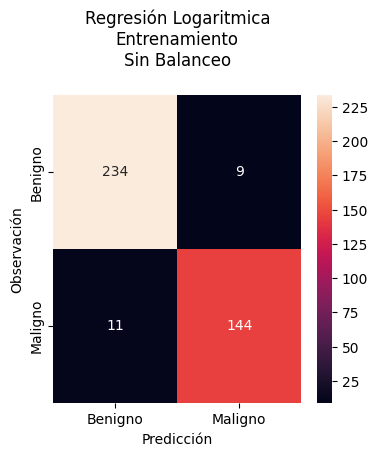

Cantidad   (Benigno): 243
Cantidad   (Maligno): 155
Cantidad     (Total): 398
Exactitud  de  modelo: 94.9749 %






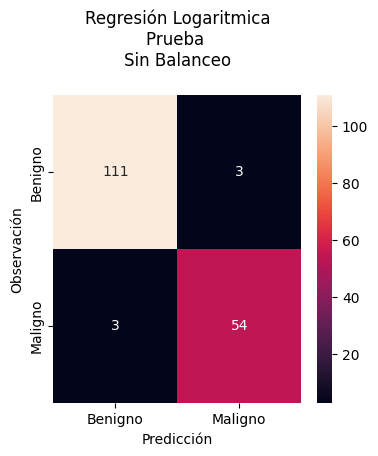

Cantidad   (Benigno): 114
Cantidad   (Maligno): 57
Cantidad     (Total): 171
Exactitud  de  modelo: 96.4912 %
Precisión en la Predicción de tumores Malignos: 94.7368 % 





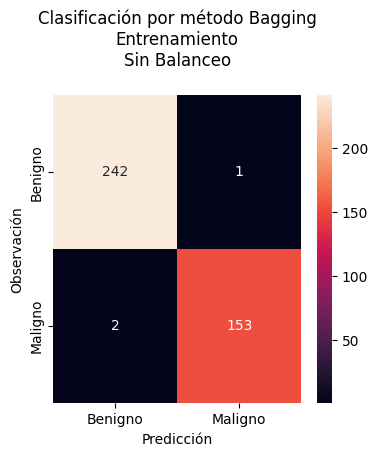

Cantidad   (Benigno): 243
Cantidad   (Maligno): 155
Cantidad     (Total): 398
Exactitud  de  modelo: 99.2462 %






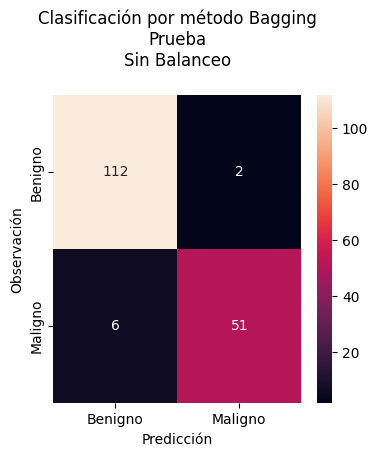

Cantidad   (Benigno): 114
Cantidad   (Maligno): 57
Cantidad     (Total): 171
Exactitud  de  modelo: 95.3216 %
Precisión en la Predicción de tumores Malignos: 89.4737 % 





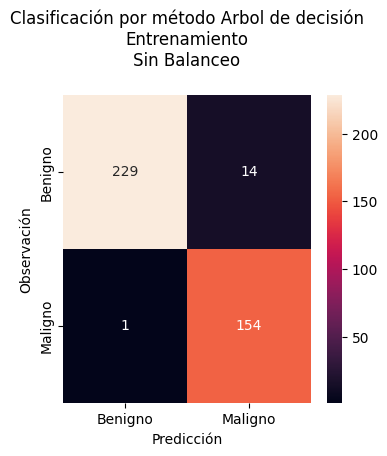

Cantidad   (Benigno): 243
Cantidad   (Maligno): 155
Cantidad     (Total): 398
Exactitud  de  modelo: 96.2312 %






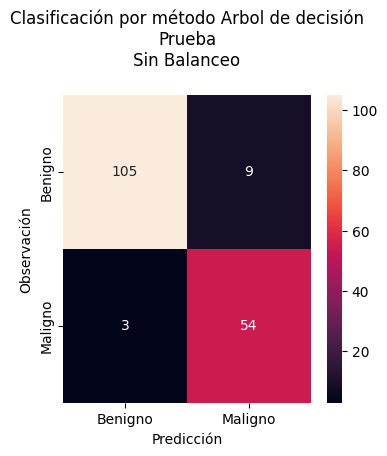

Cantidad   (Benigno): 114
Cantidad   (Maligno): 57
Cantidad     (Total): 171
Exactitud  de  modelo: 92.9825 %
Precisión en la Predicción de tumores Malignos: 94.7368 % 





Distribución  antes  de balanceo Over Sampler: 398
Distribución despues de balanceo Over Sampler: 486


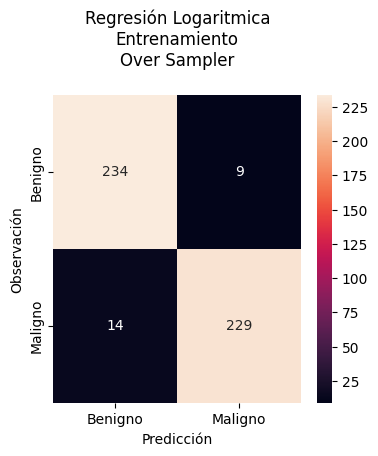

Cantidad   (Benigno): 243
Cantidad   (Maligno): 243
Cantidad     (Total): 486
Exactitud  de  modelo: 95.2675 %






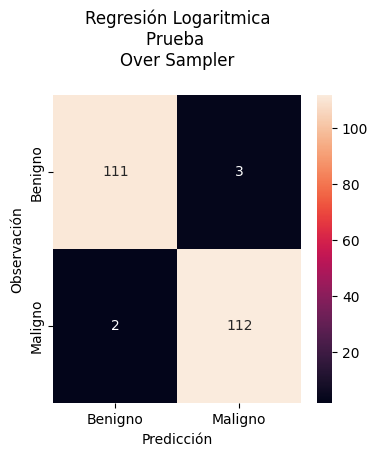

Cantidad   (Benigno): 114
Cantidad   (Maligno): 114
Cantidad     (Total): 228
Exactitud  de  modelo: 97.8070 %
Precisión en la Predicción de tumores Malignos: 98.2456 % 





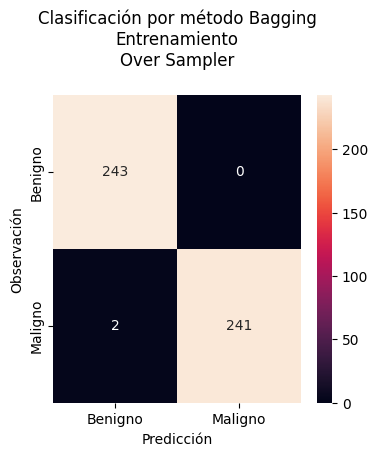

Cantidad   (Benigno): 243
Cantidad   (Maligno): 243
Cantidad     (Total): 486
Exactitud  de  modelo: 99.5885 %






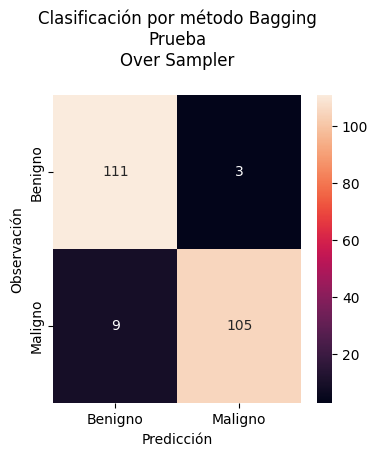

Cantidad   (Benigno): 114
Cantidad   (Maligno): 114
Cantidad     (Total): 228
Exactitud  de  modelo: 94.7368 %
Precisión en la Predicción de tumores Malignos: 92.1053 % 





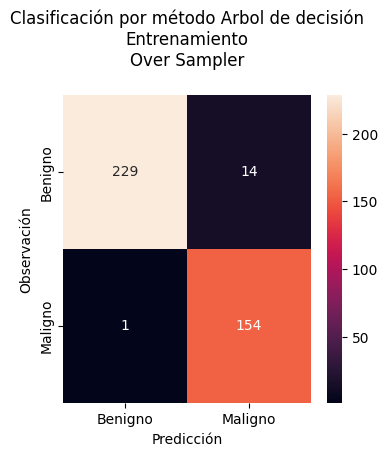

Cantidad   (Benigno): 243
Cantidad   (Maligno): 155
Cantidad     (Total): 398
Exactitud  de  modelo: 96.2312 %






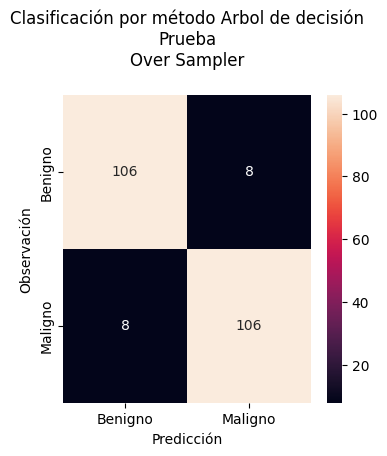

Cantidad   (Benigno): 114
Cantidad   (Maligno): 114
Cantidad     (Total): 228
Exactitud  de  modelo: 92.9825 %
Precisión en la Predicción de tumores Malignos: 92.9825 % 





Distribución  antes  de balanceo Under Sampler: 398
Distribución despues de balanceo Under Sampler: 310


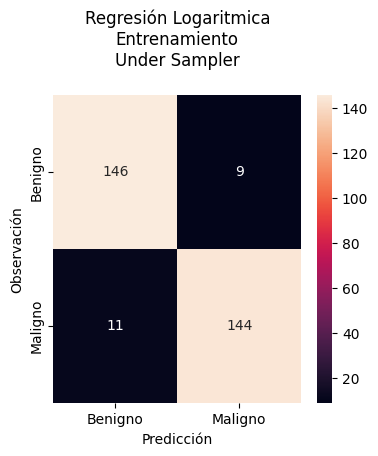

Cantidad   (Benigno): 155
Cantidad   (Maligno): 155
Cantidad     (Total): 310
Exactitud  de  modelo: 93.5484 %






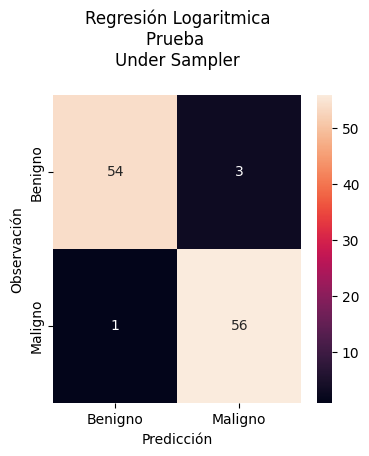

Cantidad   (Benigno): 57
Cantidad   (Maligno): 57
Cantidad     (Total): 114
Exactitud  de  modelo: 96.4912 %
Precisión en la Predicción de tumores Malignos: 98.2456 % 





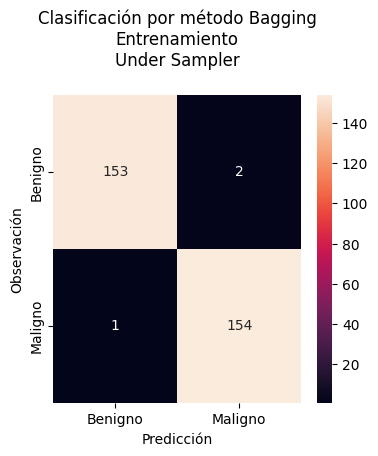

Cantidad   (Benigno): 155
Cantidad   (Maligno): 155
Cantidad     (Total): 310
Exactitud  de  modelo: 99.0323 %






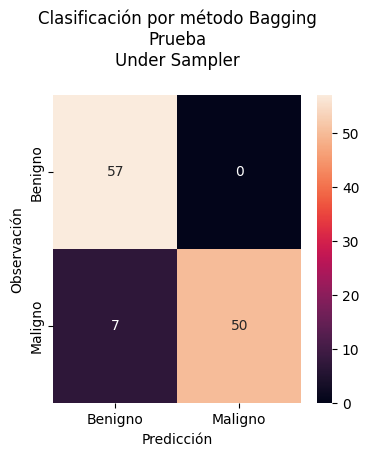

Cantidad   (Benigno): 57
Cantidad   (Maligno): 57
Cantidad     (Total): 114
Exactitud  de  modelo: 93.8596 %
Precisión en la Predicción de tumores Malignos: 87.7193 % 





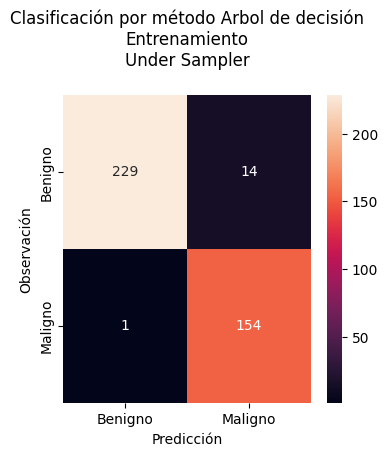

Cantidad   (Benigno): 243
Cantidad   (Maligno): 155
Cantidad     (Total): 398
Exactitud  de  modelo: 96.2312 %






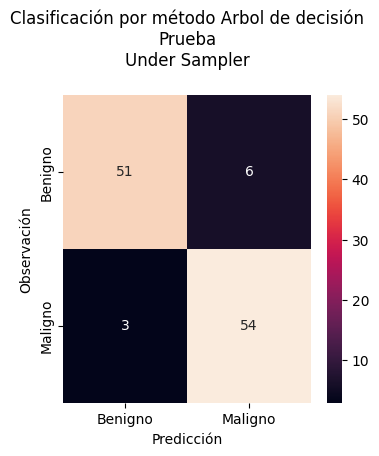

Cantidad   (Benigno): 57
Cantidad   (Maligno): 57
Cantidad     (Total): 114
Exactitud  de  modelo: 92.1053 %
Precisión en la Predicción de tumores Malignos: 94.7368 % 





Distribución  antes  de balanceo SMOTE Sampler: 398
Distribución despues de balanceo SMOTE Sampler: 470


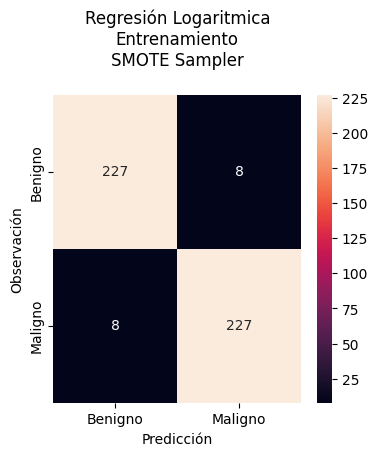

Cantidad   (Benigno): 235
Cantidad   (Maligno): 235
Cantidad     (Total): 470
Exactitud  de  modelo: 96.5957 %






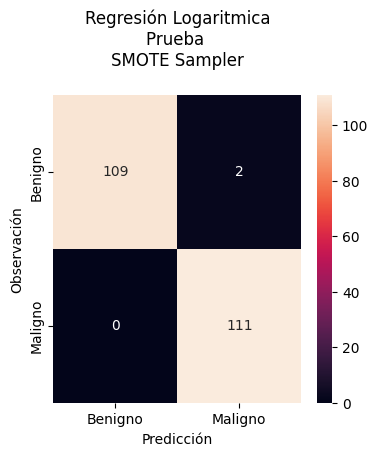

Cantidad   (Benigno): 111
Cantidad   (Maligno): 111
Cantidad     (Total): 222
Exactitud  de  modelo: 99.0991 %
Precisión en la Predicción de tumores Malignos: 100.0000 % 





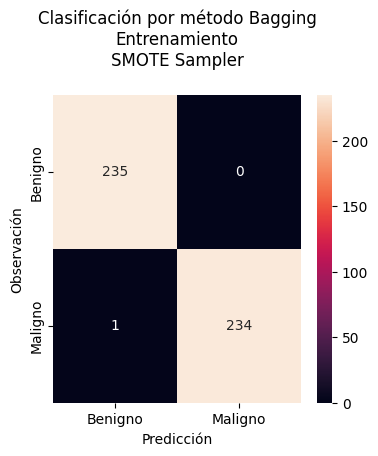

Cantidad   (Benigno): 235
Cantidad   (Maligno): 235
Cantidad     (Total): 470
Exactitud  de  modelo: 99.7872 %






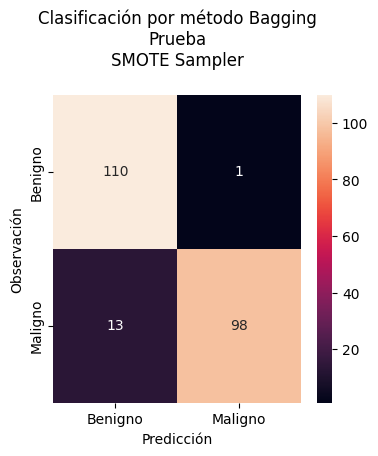

Cantidad   (Benigno): 111
Cantidad   (Maligno): 111
Cantidad     (Total): 222
Exactitud  de  modelo: 93.6937 %
Precisión en la Predicción de tumores Malignos: 88.2883 % 





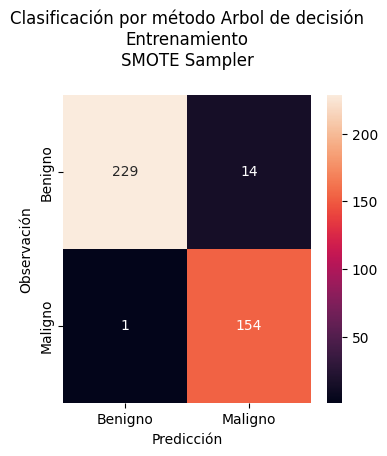

Cantidad   (Benigno): 243
Cantidad   (Maligno): 155
Cantidad     (Total): 398
Exactitud  de  modelo: 96.2312 %






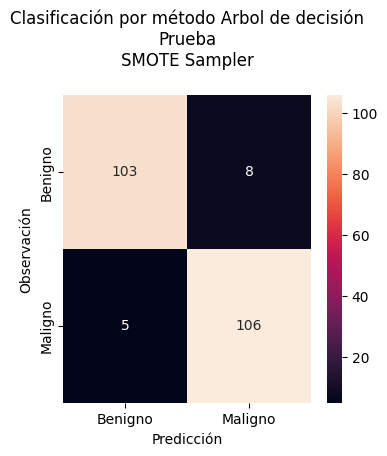

Cantidad   (Benigno): 111
Cantidad   (Maligno): 111
Cantidad     (Total): 222
Exactitud  de  modelo: 94.1441 %
Precisión en la Predicción de tumores Malignos: 95.4955 % 



El modelo con el mejor acierto a los Canceres Malignos
Tomando los datos de prueba es: RegLog SMOTE Sampler, con un procentaje de acierto del 100.00 %


In [10]:
PPM_L={}
print (f"\n\033[4;34m   Pruebas de modelos   \033[0m")

#Sin Balanceo de clases
PPM_L["RegLog Sin Balanceo"]=modeloRegLog(xTrainCopy,yTrainCopy,xTestCopy,yTestCopy,TipoBalanceo="Sin Balanceo")
PPM_L["Bagging Sin Balanceo"]=modeloBagg(xTrainCopy,yTrainCopy,xTestCopy,yTestCopy,TipoBalanceo="Sin Balanceo")
PPM_L["ArbDes Sin Balanceo"]=modeloArbDes(xTrainCopy,yTrainCopy,xTestCopy,yTestCopy,TipoBalanceo="Sin Balanceo")

#Balanceo de clases usando oversampler aleatorio
oversampler = RandomOverSampler(sampling_strategy='minority')
xTrain, yTrain = oversampler.fit_resample(xTrainCopy, yTrainCopy)
xTest, yTest = oversampler.fit_resample(xTestCopy, yTestCopy)
print (f"\n\nDistribución  antes  de balanceo Over Sampler: {yTrainCopy.count():.0f}")
print (f"Distribución despues de balanceo Over Sampler: {yTrain.count():.0f}")
PPM_L["RegLog Over Sampler"]=modeloRegLog(xTrain,yTrain,xTest,yTest,TipoBalanceo="Over Sampler")
PPM_L["Bagging Over Sampler"]=modeloBagg(xTrain,yTrain,xTest,yTest,TipoBalanceo="Over Sampler")
PPM_L["ArbDes Over Sampler"]=modeloArbDes(xTrainCopy,yTrainCopy,xTest,yTest,TipoBalanceo="Over Sampler")

#Balanceo de clases usando undersampler aleatorio
undersampler = NearMiss(n_neighbors=4, version=2) #ratio=0.5, random_state=1
xTrain, yTrain = undersampler.fit_resample(xTrainCopy, yTrainCopy)
xTest, yTest = undersampler.fit_resample(xTestCopy, yTestCopy)
print (f"\n\nDistribución  antes  de balanceo Under Sampler: {yTrainCopy.count():.0f}")
print (f"Distribución despues de balanceo Under Sampler: {yTrain.count():.0f}")
PPM_L["RegLog Under Sampler"]=modeloRegLog(xTrain,yTrain,xTest,yTest,TipoBalanceo="Under Sampler")
PPM_L["Bagging Under Sampler"]=modeloBagg(xTrain,yTrain,xTest,yTest,TipoBalanceo="Under Sampler")
PPM_L["ArbDes Under Sampler"]=modeloArbDes(xTrainCopy,yTrainCopy,xTest,yTest,TipoBalanceo="Under Sampler")

#Balanceo de clases usando SMOTETomek
smotesampler = SMOTETomek(random_state=42)
xTrain, yTrain = smotesampler.fit_resample(xTrainCopy, yTrainCopy)
xTest, yTest = smotesampler.fit_resample(xTestCopy, yTestCopy)
print (f"\n\nDistribución  antes  de balanceo SMOTE Sampler: {yTrainCopy.count():.0f}")
print (f"Distribución despues de balanceo SMOTE Sampler: {yTrain.count():.0f}")
PPM_L["RegLog SMOTE Sampler"]=modeloRegLog(xTrain,yTrain,xTest,yTest,TipoBalanceo="SMOTE Sampler")
PPM_L["Bagging SMOTE Sampler"]=modeloBagg(xTrain,yTrain,xTest,yTest,TipoBalanceo="SMOTE Sampler")
PPM_L["ArbDes SMOTE Sampler"]=modeloArbDes(xTrainCopy,yTrainCopy,xTest,yTest,TipoBalanceo="SMOTE Sampler")

maxPM=0
for modM in PPM_L:
  if PPM_L[modM]>maxPM: 
    maxPM=PPM_L[modM]
    maxMo=modM

print(f"\033[7;36mEl modelo con el mejor acierto a los Canceres Malignos\nTomando los datos de prueba es: {maxMo}, con un procentaje de acierto del {maxPM*100:.2f} %\033[0m")
    